本章将研究如何在数据集并未明确标识结果的前提下，从中提取出重要的潜在特征来。

　　和聚类一样，这些方法的目的不是为了预测，而是要尝试最数据进行特征识别，并且告诉我们值得关注的重要信息。

　　“ 鸡尾酒会问题”（cocktail party problem）是在计算机语音识别领域的一个问题，当前语音识别技术已经可以以较高精度识别一个人所讲的话，但是当说话的人数为两人或者多人时，语音识别率就会极大的降低，这一难题被称为鸡尾酒会问题。这个问题可以说明寻找独立特征的重要性。

一.搜集一组新闻

(一)选择新闻来源

　　新建一个名为newsfeatures.py的文件，加入下列代码。

In [68]:
import feedparser
f = feedparser.parse( 'http://feeds.washingtonpost.com/rss/homepage')
for e in f.entries:
    print(e.description.encode('utf8'))

b'U.S. Special Forces and airstrikes helped push the extremists from their onetime stronghold of Sirte. But the task of resurrecting the deeply scarred city has been painful and costly for the residents who remained and for those who are returning to a landscape of obliterated houses and streets covered in garbage.'
b'The clamor demonstrated that the party lacks a front-runner or someone who could easily unite the key coalitions of women, minorities and working-class voters.'


AttributeError: object has no attribute 'description'

In [76]:
import feedparser
import re

#最开始先用一个列表存储所有要分析的RSS列表
feedlist=['http://syndication.dp.discovery.com/rss/Discovery+News',
         'http://www.chinadaily.com.cn/rss/china_rss.xml']

def stripHTML(h):
    p = ''#首先将p定义为一个空的字符串
    s = 0#赋初值令s=0
    for c in h:#这里会遍历出h中的每一个字母
        if c=='<':s=1
        elif c=='>':
            s=0
            p+=' '
        elif s==0:p+=c
    return p 

def separatewords(text):
    splitter = re.compile('\\W*')
    return [s.lower() for s in splitter.split(text) if len(s)>3]
    #这儿同时加一个操作就是把所有字母变成小写字母，并且过滤掉小于3个字母的单词

def getarticlewords():
    allwords = {}#字典，最终用于记录单词在所有文章中被使用的次数
    articlewords = [] #列表，最终用于记录单词在每篇文章中出现的次数
    articletitles = []#最终会成为一个文章标题的列表
    ec=0
    # 函数第一步：遍历每个订阅源，得到RSS的全部内容
    for feed in feedlist:
        try:
            f = feedparser.parse(feed)
        except IOError:
            continue

        # 函数第二步：遍历所有RSS中的每篇文章
        for e in f.entries:#f.entries就是每一篇新闻的文章，这里对它们进行遍历

            #跳过已提取过的文章
            if e.title in articletitles:continue

            #提取单词            
            #第一步：获得文章内容，提取title和description，合并为txt
            txt = e.title.encode('utf8') + stripHTML(e.description.encode('utf8'))
            #第二步：分词，得到分词列表
            words = separatewords(txt)
            articlewords.append({})#此时articlewords=[{}]
            #articletitles=[标题1,标题2,...]
            articletitles.append(e.title)

            #第三步：对单词进行计数
            #在allwords和articlewords中增加针对当前单词的计数
            for word in words:
                allwords.setdefault(word,0)
                allwords[word] += 1
                articlewords[ec].setdefault(word,0)
                articlewords[ec][word] += 1
            ec += 1
        return allwords,articlewords,articletitles  

def makematrix(allw,articlew):
    wordvec = []

    #只考虑那些普通的但又不至于非常普通的单词
    for w,c in allw.items():
        #筛选出在超过三篇文章中出现过，但在所有文章中出现的比例小于60%的单词
        if c>3 and c<len(articlew)*0.6:
            wordvec.append(w)

        #构造单词矩阵
    L1 = [[(word in f and f[word] or 0) for word in wordvec]
                 for f in articlew]
    return L1,wordvec


书本上的RSS源很多都打不开，也许是网页过期的原因，也有可能被墙了，下面给出一些可以打开的RSS源，大家可以根据需要修改：

http://feeds.washingtonpost.com/rss/homepage

http://syndication.dp.discovery.com/rss/Discovery+News

http://www.chinadaily.com.cn/rss/china_rss.xml

(二)下载新闻来源
　　有了RSS订阅源以后，我们要构造一个类似第三章的矩阵，大致为下面这样

在本例中，行对应于各类文章，列对应于文章中的单词，矩阵中的每一个数字则代表了某个单词在一篇给定文章中出现的次数。

　　下面开始利用Python代码实现这个矩阵。

1.去除html标记

　　书本利用stripHTML函数去除HTML标记，大体思路如下：

　　这儿的参数h，是每篇文章的entries经过遍历后得到的e的description，说得有点拗口，直接上例子，我们在这儿先分别解释代码中的f,f.entries,e以及最后要去除HTML标记的e.description分别是什么。

In [77]:
import feedparser
f = feedparser.parse('http://syndication.dp.discovery.com/rss/Discovery+News')
#feedparser.parse:Parse a feed from a URL, file, stream, or string.return: A :class:`FeedParserDict`.
#从一个URL, file, stream, or string中解析代码，返回一个FeedParser字典

In [78]:
f

{'bozo': 0,
 'encoding': 'utf-8',
 'entries': [{'author': 'Rossella_Lorenzi@discovery.com (Rossella Lorenzi)',
   'author_detail': {'email': 'Rossella_Lorenzi@discovery.com',
    'name': 'Rossella Lorenzi'},
   'authors': [{'email': 'Rossella_Lorenzi@discovery.com',
     'name': 'Rossella Lorenzi'}],
   'guidislink': False,
   'id': 'f63ece25-fdb0-6110-df8b-487e387bea83',
   'link': 'http://news.discovery.com/history/archaeology/dna-obtained-from-2500-year-old-phoenician-160525.htm#mkcpgn=rssnws1',
   'links': [{'href': 'http://news.discovery.com/history/archaeology/dna-obtained-from-2500-year-old-phoenician-160525.htm#mkcpgn=rssnws1',
     'rel': 'alternate',
     'type': 'text/html'}],
   'published': 'Wed, 25 May 2016 14:00:00 -0400',
   'published_parsed': time.struct_time(tm_year=2016, tm_mon=5, tm_mday=25, tm_hour=18, tm_min=0, tm_sec=0, tm_wday=2, tm_yday=146, tm_isdst=0),
   'summary': 'Analysis of the ancient man&#039;s DNA reveal he had European ancestry.',
   'summary_detail

经过解析后的xml代码和之前有什么区别呢？我在这里贴一些节选

　　解析前的RSS源是这样的：

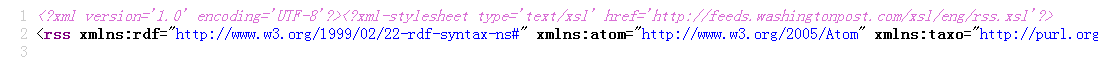

解释之后就是一个FeedParser字典，f.entries为一个列表，包含数据的每一块。输出如下

In [79]:
print(f.entries)

[{'title': 'DNA Captured From 2,500-Year-Old Phoenician', 'title_detail': {'type': 'text/plain', 'language': None, 'base': 'http://syndication.dp.discovery.com/rss/Discovery+News', 'value': 'DNA Captured From 2,500-Year-Old Phoenician'}, 'summary': 'Analysis of the ancient man&#039;s DNA reveal he had European ancestry.', 'summary_detail': {'type': 'text/html', 'language': None, 'base': 'http://syndication.dp.discovery.com/rss/Discovery+News', 'value': 'Analysis of the ancient man&#039;s DNA reveal he had European ancestry.'}, 'links': [{'rel': 'alternate', 'type': 'text/html', 'href': 'http://news.discovery.com/history/archaeology/dna-obtained-from-2500-year-old-phoenician-160525.htm#mkcpgn=rssnws1'}], 'link': 'http://news.discovery.com/history/archaeology/dna-obtained-from-2500-year-old-phoenician-160525.htm#mkcpgn=rssnws1', 'id': 'f63ece25-fdb0-6110-df8b-487e387bea83', 'guidislink': False, 'authors': [{'name': 'Rossella Lorenzi', 'email': 'Rossella_Lorenzi@discovery.com'}], 'author'

然后我们遍历f.entries列表的每一项，得到一系列字典

In [80]:
for e in f.entries:
    print(e)


{'title': 'DNA Captured From 2,500-Year-Old Phoenician', 'title_detail': {'type': 'text/plain', 'language': None, 'base': 'http://syndication.dp.discovery.com/rss/Discovery+News', 'value': 'DNA Captured From 2,500-Year-Old Phoenician'}, 'summary': 'Analysis of the ancient man&#039;s DNA reveal he had European ancestry.', 'summary_detail': {'type': 'text/html', 'language': None, 'base': 'http://syndication.dp.discovery.com/rss/Discovery+News', 'value': 'Analysis of the ancient man&#039;s DNA reveal he had European ancestry.'}, 'links': [{'rel': 'alternate', 'type': 'text/html', 'href': 'http://news.discovery.com/history/archaeology/dna-obtained-from-2500-year-old-phoenician-160525.htm#mkcpgn=rssnws1'}], 'link': 'http://news.discovery.com/history/archaeology/dna-obtained-from-2500-year-old-phoenician-160525.htm#mkcpgn=rssnws1', 'id': 'f63ece25-fdb0-6110-df8b-487e387bea83', 'guidislink': False, 'authors': [{'name': 'Rossella Lorenzi', 'email': 'Rossella_Lorenzi@discovery.com'}], 'author':

In [81]:
for e in f.entries:
    print(e.description.encode('utf8'))

b'Analysis of the ancient man&#039;s DNA reveal he had European ancestry.'
b'The ancient remedy could provide a new weapon against microbes Continue reading \xe2\x86\x92'
b'A Japanese aquarium said it had hatched two Humboldt penguin chicks, the first time the technique has been successfully deployed for the species.'
b'Neanderthals built some of the world&#039;s earliest constructions, which were just found deep in a French cave.'
b'Adding 4G service to the laptop would making getting online easier, especially when Wi-Fi connection was spotty.'
b'When Mars was a wet world, did its oceans experience powerful tsunamis spawned by meteorite impacts?'
b'New research may help explain the growing obsession in some countries with short-nosed dogs.'
b'Most of us probably breathe a sigh of relief when the captain promises &quot;a smooth ride&quot; to wherever we&#039;re flying. But, as DNews explains, turbulence is really no big deal.'
b'Farmed Atlantic salmon often suffer from such high levels

e.description的输出如下,有时我们可以看到这里边有很多html标记，我们编写stripHTML的目的就是把这些HTML标记去除

In [23]:
def stripHTML(h):
    p = ''#首先将p定义为一个空的字符串
    s = 0#赋初值令s=0
    for c in h:#这里会遍历出h中的每一个字母
        if c=='<':s=1
        elif c=='>':
            s=0
            p+=' '
        elif s==0:p+=c
    return p  

 2.分词

　　利用正则表达式对英文进行分词。

In [24]:
def separatewords(text):
    splitter = re.compile('\\W*')
    return [s.lower() for s in splitter.split(text) if len(s)>3]
    #这儿同时加一个操作就是把所有字母变成小写字母，并且过滤掉小于3个字母的单词

3.逐个提取单词并计数
　　通过getarticlewords可以得到allwords,articlewords,和articletitles，分别对应于所有单词的计数，每篇文章单词的计数和每篇文章的标题。

In [ ]:
def getarticlewords():
    allwords = {}#字典，最终用于记录单词在所有文章中被使用的次数
    articlewords = [] #列表，最终用于记录单词在每篇文章中出现的次数
    articletitles = []#最终会成为一个文章标题的列表
    ec=0
    # 函数第一步：遍历每个订阅源，得到RSS的全部内容
    for feed in feedlist:
        f = feedparser.parse(feed)
        
        # 函数第二步：遍历所有RSS中的每篇文章
        for e in f.entries:#f.entries就是每一篇新闻的文章，这里对它们进行遍历
            
            #跳过已提取过的文章
            if e.title in articletitles:continue
                
            #提取单词            
            #第一步：获得文章内容，提取title和description，合并为txt
            txt = e.title.encode('utf8') + stripHTML(e.description.encode('utf8'))
            #第二步：分词，得到分词列表
            words = separatewords(txt)
            articlewords.append({})#此时articlewords=[{}]
            #articletitles=[标题1,标题2,...]
            articletitles.append(e.title)
            
            #第三步：对单词进行计数
            #在allwords和articlewords中增加针对当前单词的计数
            for word in words:
                allwords.setdefault(word,0)
                allwords[word] += 1
                articlewords[ec].setdefault(word,0)
                articlewords[ec][word] += 1
            ec += 1
        return allwords,articlewords,articletitles      

4.转换成矩阵

In [48]:
def makematrix(allw,articlew):
    wordvec = []
    
    #只考虑那些普通的但又不至于非常普通的单词
    for w,c in allw.items():
        #筛选出在超过三篇文章中出现过，但在所有文章中出现的比例小于60%的单词
        #此处可能存在错误，按文意，c 应该是某个单词在所有文章中出现的次数（一篇文章最多一次），而不是重复总次数
        if c>3 and c<len(articlew)*0.6:
            wordvec.append(w)
            
        #构造单词矩阵
    L1 = [[(word in f and f[word] or 0) for word in wordvec]
                 for f in articlew]
    return L1,wordvec
            

In [40]:
word = "hello"
word1 = "world"
alw = {}
alw.setdefault(word,0)
alw[word] += 1
alw.setdefault(word1,0)
alw[word1] += 1
alw.items()

dict_items([('hello', 1), ('world', 1)])

In [43]:
word = "hello"
word1 = "world"
alw = []
alw.append({})
alw[0].setdefault(word,0)
alw[0][word] += 1
alw.append({})
alw[1].setdefault(word1,0)
alw[1][word1] += 1
alw

[{'hello': 1}, {'world': 1}]

In [45]:
allw,artw,artt = getarticlewords()

TypeError: must be str, not int

In [47]:
for e in f.entries:
    txt = stripHTML(e.description.encode('utf8'))

TypeError: must be str, not int

以上错误应该跟新闻订阅源的数据格式有关

## 非负矩阵因式分解

矩阵因式分解与整数影视分解形式上比较类似，就是将一个M(m*n)的矩阵分解成M1(m*i)*M2(i*n)的形式。M1的列是新的feature对原有行的贡献，M2的行是通过原有矩阵列组合成的feature。NNMF大致的算法框架如下：

    定义一个函数计算用来两个矩阵的差异程度（每个对应元素相减后平方的和）
    随机生成2个矩阵(m*r维和r*n维)记为A（权重矩阵）,B（特征矩阵）
    计算A*B与输入的m*n的数据矩阵的差异，足够小则停止，否则继续
    按一定规则调整A，B的值后转3

NNMF无需训练，可以发现新的分类，对于文章而言发现文章的主题（一系列权重较大的词组）。

In [49]:
from numpy import *
L1 = [[1,2,3],[4,5,6]]
L1

[[1, 2, 3], [4, 5, 6]]

In [51]:
m1 = matrix(L1)
m1

matrix([[1, 2, 3],
        [4, 5, 6]])

In [52]:
m2 = matrix([[1,2],[3,4],[5,6]])
m2

matrix([[1, 2],
        [3, 4],
        [5, 6]])

In [53]:
m1*m2

matrix([[22, 28],
        [49, 64]])

In [54]:
shape(m2)

(3, 2)

In [55]:
a1 = m1.A#转换成数组
a1

array([[1, 2, 3],
       [4, 5, 6]])

矩阵因式分解的目的呢，就是把矩阵B拆分成为两个矩阵相乘，比如矩阵F和矩阵W，这样B=W*F。矩阵的乘法当时寿老师教的很清楚，第一个矩阵（比如W）的列必须于第二个矩阵（比如F）的行数相等才能相乘，乘积矩阵（比如B）的每个元素的取值，是通过将矩阵W中相同行的值与矩阵F中相同列的值相乘，然后将乘积相加所得。（这里我不举例子了，随便Google就有了）。这里将B拆分为F和W的乘积，F代表特征矩阵，W代表权值矩阵，下面详细说说这两个东西。

F特征矩阵：在该矩阵中，每一个特征对应一行，每个单词对应一列，矩阵中的数字代表了某个单词相对于某个特征的重要程度；

W权值矩阵：在改矩阵中，每一行对应一本书，每一列对应一个特征，矩阵中的数字代表了将某个特征应用于某篇文章的程度；

这样W*F就可以重构出B，一行对应一本书，一列对应一个单词。

通过计算最佳的特征矩阵和权值矩阵，算法尝试尽可能大地来重新构造文章矩阵。这里我们先定义一种方法来衡量最终结果与理想结

In [84]:
from numpy import *
def difcost(a,b):
    dif = 0
    #遍历矩阵的行列
    for i in range(shape(a)[0]):
        for j in range(shape(a)[1]):
            #将差值的平方相加
            dif += pow(a[i,j]-b[i,j],2)
    return dif

### 使用乘法更新法则搜索最优解

函数difcost针对两个同样大小的矩阵遍历其中的每个值，并将两者的间差值的平方累加起来。

下面我们需要一种方法能够逐渐地更新矩阵，以使成本函数的计算值逐步降低。《集体智慧编程学习之优化系统》里的退火法和遗传算法都能满足要求。这里我来学习一种更为的方法，乘法更新矩阵法则。法则的具体原理先不学习，先直接拿来用。有兴趣的看这篇论文《Algorithms for Non-negative Matrix Factorization》

这个法则产生四个新的更新矩阵：

hn：转置后的权重矩阵与数据矩阵相乘而来；

hd：转置后的权重矩阵与原权重矩阵相乘，再与特征矩阵相乘而来；

wn：数据矩阵与转置后的特征矩阵相乘而来；

wd：权重矩阵与特征矩阵相乘，再与转置后的特征矩阵相乘而来；

更新特征矩阵和权重矩阵，我们将特征矩阵中的每个值与hn中的对应值相乘，并除以hd中的对应值；再将权重矩阵中的每个值与wn中的对应值相乘，并除以wd中的对应值下面看用python的算法实现：

In [85]:
def factorize(v,pc=10,iter=50):
    ic = shape(v)[0]
    fc = shape(v)[1]
    
    #以随机值初始化权重矩阵和特征矩阵
    #前一矩阵的列数要与后一矩阵相等，积的列数与前一矩阵行数相等，行数与后一矩阵列数相等
    w = matrix([[random.random() for j in range(pc)] for i in range(ic)])
    h = matrix([[random.random() for i in range(fc)] for i in range(pc)])
    
    #最多执行iter次操作
    for i in range(iter):
        #计算出跟数据矩阵一样大小的矩阵
        wh = w*h
        
        #计算差值的平方和
        cost = difcost(v,wh)
        
        if i%10==0: print(cost)
            
        #如果矩阵已分解彻底，则立即停止
        if cost==0:break
            
        #更新特征矩阵
        #hn是转置之后的权重矩阵与数据矩阵相乘得到
        hn = (transpose(w)*v)
        #hd由转置之后的权重矩阵与原权重矩阵相乘，再与特征矩阵相乘得到
        hd = (transpose(w)*w*h)
        
        h=matrix(array(h)*array(hn)/array(hd))
        
        #更新权重矩阵
        #wn由数据矩阵与转置后的特征矩阵相乘得到
        wn = (v*transpose(h))
        #wd由权重矩阵与特征矩阵相乘，再与转置后特征矩阵相乘得到
        wd = (w*h*transpose(h))
        
        w = matrix(array(w)*array(wn)/array(wd))
        
    return w,h
        

参数pc指定我们希望找到的特征数，iter是最多执行次数。

来看看我机器执行的测试：

In [86]:
w,h=factorize(m1*m2,pc=3,iter=100)


7523.22264461
0.570198977371
0.0258549174037
0.00122829373867
5.89157475872e-05
2.8317985959e-06
1.36172839396e-07
6.54880159456e-09
3.14950750374e-10
1.51469621097e-11


In [87]:
w*h

matrix([[ 21.99999939,  28.00000048],
        [ 49.00000027,  63.99999979]])

测试数据用的例子：每一行都是一本书，每一列都代表一个词，数组中的数字代表这个词在这本书中出现的次数或者TF-IDF值：

In [98]:
books = [      
  [2, 3, 3, 12, 13, 12],      
  [3, 3, 1, 13, 12, 11],   
  [1, 10, 3, 5, 11, 13],      
  [13, 12, 11, 1, 3, 3],      
  [12, 13, 12, 3, 2, 2],      
  [5, 11, 13, 3, 1, 10]    
]    

v=matrix(books)

w,f=factorize(v,pc=6)

1993.22555289
41.4919137555
21.7412734572
14.164815717
7.9169743513


In [99]:
w

matrix([[  1.24585521e-01,   1.48729284e+00,   4.04960882e-02,
           1.70385597e-01,   2.31012462e-01,   1.85752661e-01],
        [  7.64551837e-02,   1.48075816e+00,   3.17867242e-03,
           3.35106992e-03,   2.33748951e-01,   3.52256488e-01],
        [  2.13662676e+00,   6.86159509e-01,   8.69306616e-02,
           2.11246575e-01,   1.33442067e-02,   1.22689810e-03],
        [  3.82264121e-01,   3.11470081e-03,   1.51652956e+00,
           2.83230474e-01,   3.65328094e-01,   8.19199765e-01],
        [  1.40799516e-01,   1.58967327e-03,   1.36843270e+00,
           3.81414366e-01,   1.28555766e+00,   3.27296870e-01],
        [  5.78398824e-01,   4.00724177e-02,   1.43524926e-01,
           1.88238841e+00,   1.50394226e-01,   3.68691695e-01]])

In [100]:
f

matrix([[  1.94933307e-01,   3.88442298e+00,   6.25577686e-01,
           7.21465882e-04,   2.28720153e+00,   3.37105106e+00],
        [  9.49494312e-03,   8.01863536e-01,   5.34185238e-02,
           7.83898047e+00,   8.21750467e+00,   7.19324489e+00],
        [  4.32131453e+00,   4.97781946e+00,   3.91521132e+00,
           2.38181319e-04,   9.80561229e-01,   3.11244043e-05],
        [  8.33564258e-01,   3.70936527e+00,   5.74944971e+00,
           9.64640355e-01,   5.46903799e-05,   3.94897603e+00],
        [  2.94213935e+00,   2.90953848e+00,   2.76344671e+00,
           1.70721860e+00,   2.91026294e-01,   1.25053850e-02],
        [  6.11148753e+00,   1.18477322e+00,   2.53927053e+00,
           9.15675242e-01,   3.28171497e-01,   6.57233824e-01]])

In [101]:
w*f

matrix([[  2.17032723,   3.40236782,   2.40562796,  12.38779774,
          12.67469567,  11.91626749],
        [  2.88602587,   2.61004907,   1.69906784,  12.33253591,
          12.52975022,  11.15686181],
        [  1.02151578,  10.10636329,   2.96817455,   5.60803508,
          10.61495348,  12.97357488],
        [ 12.94541289,  12.12049081,  10.89498989,   1.67208449,
           2.76213382,   2.97252859],
        [ 12.04138361,  12.90296775,  12.02245726,   2.87524223,
           2.15849351,   2.22350302],
        [  4.99817319,  10.85017951,  13.10041632,   2.72476388,
           1.95781066,   9.91577127]])

In [107]:
from numpy import *
def showfeatures(w,h,wordvec,out="testfeatures.txt"):
    outfile = open(out,'w')
    pc,wc = shape(h)
   
    #遍历所有特征
    for i in range(pc):
        slist = []
        #构造一个包含单词及其权重数据的列表
        for j in range(wc):
            slist.append((h[i,j],wordvec[j]))
        #将单词列表倒序排列
        slist.sort()
        slist.reverse()
        
        #打印开始的六个元素
        n = [s[1] for s in slist[0:6]]
        outfile.write(str(n)+'\n')
        
    

In [108]:
aa = showfeatures(w,f,books)

构建一个函数将重要特征提取出来

In [109]:
from numpy import *
def showfeatures(w,h,titles,wordvec,out="features.txt"):
    outfile = open(out,'w')
    pc,wc = shape(h)
    toppatterns = [[] for i in range(len(titles))]
    patternnames=[]
    
    #遍历所有特征
    for i in range(pc):
        
        #构造一个包含单词及其权重数据的列表
        slist = []
        for j in range(wc):
            slist.append((h[i,j],wordvec[j]))
        #将单词列表倒序排列
        slist.sort()
        slist.reverse()
        
        #打印开始的六个元素
        n = [s[1] for s in slist[0:6]]
        outfile.write(str(n)+'\n')
        patternnames.append(n)
        
        #构造一个针对该特征的文章列表
        flist =[]
        for j in range(len(titles)):
            #加入文章及其权重数据
            flist.append((w[j,i],titles[j]))
            toppatterns[j].append((w[j,i],i,titles[j]))
            
        #将该列表倒序排列
        flist.sort()
        fli.reverse()
        
        #显示前三篇文章
        for f in flist[0:3]:
            outfile.write(str(f)+'\n')
            outfile.write('\n')
            
    outfile.write('\n')
    #返回模式名称
    return toppatterns,patternnames
    

In [ ]:
topp,pn = showfeatures(weights,feat,artt,wordvec)

In [ ]:
import urllib2 #爬虫所需
from numpy import *
######这段代码的作用是，根据一组股票代码将一堆csv文件下载到本地，并放入一个字典中。
####它还记载了这些股票中拥有交易记录的最小交易日天数，以此作为观测矩阵的行数
# tickers=['YHOO','AVP','BIIB','BP','CL','CVX',
#          'DNA','EXPE','GOOG','PG','XOM','AMGN']#将要提取特征的股票代码存入一个列表中

tickers=['YHOO','AVP','BIIB']

shortest=300 #建立一个变量shortest用于记录最小交易日天数，赋初值300
prices={} #建立空字典prices
dates=None #如果一个变量的值是None，它说明这个变量没有值。

for t in tickers: #遍历tickers列表中的每一个股票代码
  # 打开URL
  rows=urllib2.urlopen('http://ichart.finance.yahoo.com/table.csv?'+\
                       's=%s&d=11&e=26&f=2006&g=d&a=3&b=12&c=1996'%t +\
                       '&ignore=.csv').readlines() #readlines() 自动将文件内容分析成一个行的列表
  #此时rows可以得到一个列表，列表的每一项对应打开的csv文件的每一个行
  
  #从每一个行中提取成交量
  prices[t]=[float(r.split(',')[5]) for r in rows[1:] if r.strip()!=''] #在price字典中把股票代码加入key，等号后面的意思是，遍历rows文件中的第二项到最后一项（因为第一项是列名，不需要遍历），如果遍历出来的东西（即r）不为空值的话，以逗号为分隔符将r进行分隔，并取第六项（即成交量），同时将成交转换为浮点数的形式
  if len(prices[t])<shortest: shortest=len(prices[t]) #len(prices[t])实际上就是字典prices的value的项数，实际意义为交易日天数，这里设置了一个条件循环，如果算出来的交易日天数小于先前的shortest，就把这个交易日赋值给shortest,这样循环下去，shortest就为最小交易日天数
  
  if not dates: #相当于if not (dates is None)
    dates=[r.split(',')[0] for r in rows[1:] if r.strip()!=''] #将dates提取出来，做法类似于上方prices[t]

####准备矩阵
l1=[[prices[tickers[i]][j] 
     for i in range(len(tickers))] 
    for j in range(shortest)] #l1为一个list，记录每个股票每天的成交量（最小天数内），l1=[[成交量，成交量，成交量],[成交量，成交量，成交量],...]
####运行NMF
w,h=nnmf.factorize(matrix(l1),pc=5)

print h
print w

# Loop over all the features
for i in range(shape(h)[0]):
  print "Feature %d" %i
  
  # Get the top stocks for this feature
  ol=[(h[i,j],tickers[j]) for j in range(shape(h)[1])]
  ol.sort()
  ol.reverse()
  for j in range(12):
    print ol[j]
  print
  
  # Show the top dates for this feature
  porder=[(w[d,i],d) for d in range(300)]
  porder.sort()
  porder.reverse()
  print [(p[0],dates[p[1]]) for p in porder[0:3]]
  print

In [114]:
from urllib.request import urlopen #爬虫所需
from numpy import *
######这段代码的作用是，根据一组股票代码将一堆csv文件下载到本地，并放入一个字典中。
####它还记载了这些股票中拥有交易记录的最小交易日天数，以此作为观测矩阵的行数
# tickers=['YHOO','AVP','BIIB','BP','CL','CVX',
#          'DNA','EXPE','GOOG','PG','XOM','AMGN']#将要提取特征的股票代码存入一个列表中

tickers=['YHOO','AVP','BIIB']

shortest=300 #建立一个变量shortest用于记录最小交易日天数，赋初值300
prices={} #建立空字典prices
dates=None #如果一个变量的值是None，它说明这个变量没有值。

for t in tickers: #遍历tickers列表中的每一个股票代码
  # 打开URL
    rows=urlopen('http://ichart.finance.yahoo.com/table.csv?'+\
                       's=%s&d=11&e=26&f=2006&g=d&a=3&b=12&c=1996'%t +\
                       '&ignore=.csv').readlines() #readlines() 自动将文件内容分析成一个行的列表
    #此时rows可以得到一个列表，列表的每一项对应打开的csv文件的每一个行

    #从每一个行中提取成交量
    prices[t]=[float(r.split(',')[5]) for r in rows[1:] if r.strip()!=''] #在price字典中把股票代码加入key，等号后面的意思是，遍历rows文件中的第二项到最后一项（因为第一项是列名，不需要遍历），如果遍历出来的东西（即r）不为空值的话，以逗号为分隔符将r进行分隔，并取第六项（即成交量），同时将成交转换为浮点数的形式
    if len(prices[t])<shortest: shortest=len(prices[t]) #len(prices[t])实际上就是字典prices的value的项数，实际意义为交易日天数，这里设置了一个条件循环，如果算出来的交易日天数小于先前的shortest，就把这个交易日赋值给shortest,这样循环下去，shortest就为最小交易日天数

    if not dates: #相当于if not (dates is None)
        dates=[r.split(',')[0] for r in rows[1:] if r.strip()!=''] #将dates提取出来，做法类似于上方prices[t]

    ####准备矩阵
    l1=[[prices[tickers[i]][j] 
     for i in range(len(tickers))] 
    for j in range(shortest)] #l1为一个list，记录每个股票每天的成交量（最小天数内），l1=[[成交量，成交量，成交量],[成交量，成交量，成交量],...]

URLError: <urlopen error [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>